# Estimation of Covid-19 death outcome risk

The target of this analysis is to train an appropriate model allowing to predict death risk of Covid-19 basing on medical data in the dataset and to interpret the model for dangerous factors estimation which may lead to death. The dataset was taken from Kaggle [COVID-19 Dataset](https://www.kaggle.com/datasets/meirnizri/covid19-dataset) and it was provided by Mexican government.

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import RandomizedSearchCV
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, confusion_matrix,classification_report
from sklearn.metrics import precision_score,recall_score,f1_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import cross_val_score


In [3]:

df = pd.read_csv("Covid Data.csv")
df.head()

,USMER,MEDICAL_UNIT,SEX,PATIENT_TYPE,DATE_DIED,INTUBED,PNEUMONIA,AGE,PREGNANT,DIABETES,...,ASTHMA,INMSUPR,HIPERTENSION,OTHER_DISEASE,CARDIOVASCULAR,OBESITY,RENAL_CHRONIC,TOBACCO,CLASIFFICATION_FINAL,ICU
0,2,1,1,1,03/05/2020,97,1,65,2,2,...,2,2,1,2,2,2,2,2,3,97
1,2,1,2,1,03/06/2020,97,1,72,97,2,...,2,2,1,2,2,1,1,2,5,97
2,2,1,2,2,09/06/2020,1,2,55,97,1,...,2,2,2,2,2,2,2,2,3,2
3,2,1,1,1,12/06/2020,97,2,53,2,2,...,2,2,2,2,2,2,2,2,7,97
4,2,1,2,1,21/06/2020,97,2,68,97,1,...,2,2,1,2,2,2,2,2,3,97


# EDA

Let's look at the data in details.

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1048575 entries, 0 to 1048574
Data columns (total 21 columns):
 #   Column                Non-Null Count    Dtype 
---  ------                --------------    ----- 
 0   USMER                 1048575 non-null  int64 
 1   MEDICAL_UNIT          1048575 non-null  int64 
 2   SEX                   1048575 non-null  int64 
 3   PATIENT_TYPE          1048575 non-null  int64 
 4   DATE_DIED             1048575 non-null  object
 5   INTUBED               1048575 non-null  int64 
 6   PNEUMONIA             1048575 non-null  int64 
 7   AGE                   1048575 non-null  int64 
 8   PREGNANT              1048575 non-null  int64 
 9   DIABETES              1048575 non-null  int64 
 10  COPD                  1048575 non-null  int64 
 11  ASTHMA                1048575 non-null  int64 
 12  INMSUPR               1048575 non-null  int64 
 13  HIPERTENSION          1048575 non-null  int64 
 14  OTHER_DISEASE         1048575 non-null  int64 
 15

All the values excluding DATE_DIED variable are integer. Let's look at this variable.

In [5]:
df.DATE_DIED.value_counts()

DATE_DIED
9999-99-99    971633
06/07/2020      1000
07/07/2020       996
13/07/2020       990
16/06/2020       979
               ...  
24/11/2020         1
17/12/2020         1
08/12/2020         1
16/03/2021         1
22/04/2021         1
Name: count, Length: 401, dtype: int64

We see that it's necessary to process this variable.
The first needed action is to create a target variable basing on DATE_DIED column.
The value 9999-99-99 in this column means that the patient didn't die owing to Covid-19 desease. Any other value means that patient died so we can create "Death" column containing only 2 values - 0 (Patient didn't die) and 1 (patient died).

In [6]:
df1 = df.copy()
df1.DATE_DIED[df['DATE_DIED'] != '9999-99-99'] = 1
df1.DATE_DIED[df['DATE_DIED'] == '9999-99-99'] = 0
df1.DATE_DIED.value_counts()

C:\Users\govin\AppData\Local\Temp\ipykernel_26996\545195272.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1.DATE_DIED[df['DATE_DIED'] != '9999-99-99'] = 1
C:\Users\govin\AppData\Local\Temp\ipykernel_26996\545195272.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1.DATE_DIED[df['DATE_DIED'] == '9999-99-99'] = 0


DATE_DIED
0    971633
1     76942
Name: count, dtype: int64

valeu_counts() function shows that the column now contains on "0" and "1" values.

In [165]:
df['DEATH'] = df1.DATE_DIED
df.head(20)

,USMER,MEDICAL_UNIT,SEX,PATIENT_TYPE,DATE_DIED,INTUBED,PNEUMONIA,AGE,PREGNANT,DIABETES,COPD,ASTHMA,INMSUPR,HIPERTENSION,OTHER_DISEASE,CARDIOVASCULAR,OBESITY,RENAL_CHRONIC,TOBACCO,CLASIFFICATION_FINAL,ICU,DEATH
0,2,1,1,1,03/05/2020,97,1,65,2,2,2,2,2,1,2,2,2,2,2,3,97,1
1,2,1,2,1,03/06/2020,97,1,72,97,2,2,2,2,1,2,2,1,1,2,5,97,1
2,2,1,2,2,09/06/2020,1,2,55,97,1,2,2,2,2,2,2,2,2,2,3,2,1
3,2,1,1,1,12/06/2020,97,2,53,2,2,2,2,2,2,2,2,2,2,2,7,97,1
4,2,1,2,1,21/06/2020,97,2,68,97,1,2,2,2,1,2,2,2,2,2,3,97,1
5,2,1,1,2,9999-99-99,2,1,40,2,2,2,2,2,2,2,2,2,2,2,3,2,0
6,2,1,1,1,9999-99-99,97,2,64,2,2,2,2,2,2,2,2,2,2,2,3,97,0
7,2,1,1,1,9999-99-99,97,1,64,2,1,2,2,1,1,2,2,2,1,2,3,97,0
8,2,1,1,2,9999-99-99,2,2,37,2,1,2,2,2,1,2,2,1,2,2,3,2,0
9,2,1,1,2,9999-99-99,2,2,25,2,2,2,2,2,2,2,2,2,2,2,3,2,0


Let's look at distribution of the target variable:

In [8]:
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns


death_dist = df.DEATH.value_counts()
plt.figure(figsize = (8,5))
sns.barplot(x = death_dist.index, y = death_dist.values)
plt.xlabel('Death or not owing to covid deasise', fontsize = 12)
plt.ylabel('Death distribution', fontsize = 12)
plt.title('Death distribution in the dataset', fontsize = 15)
plt.show()

KeyError: 'DEATH'

We can make sure that the target variable is unbalanced. It means that we need to process the dataset before modeling.

### The description of the variables:
The dataset contains the description of the variables. Let's check the description study the variables and replace the values if it's neccesary.

- sex: female or male:
1 - female, 2 - male.
- age: of the patient.
- classification_final: covid test findings. Values 1-3 mean that the patient was diagnosed with covid in different degrees. 4 or higher means that the patient is not a carrier of covid or that the test is inconclusive.
- patient type: hospitalized or not hospitalized.
1 - hospitalized, 2 - not hospitalized.
- pneumonia: whether the patient already have air sacs inflammation or not.
1 - yes, 2 - no.
- pregnancy: whether the patient is pregnant or not.
1 - yes, 2 - no.
- diabetes: whether the patient has diabetes or not.
1 - yes, 2 - no.
- copd: Indicates whether the patient has Chronic obstructive pulmonary disease or not.
1 - yes, 2 - no.
- asthma: whether the patient has asthma or not.
1 - yes, 2 - no.
- inmsupr: whether the patient is immunosuppressed or not.
1 - yes, 2 - no.
- hypertension: whether the patient has hypertension or not.
1 - yes, 2 - no.
- cardiovascular: whether the patient has heart or blood vessels related disease.
1 - yes, 2 - no.
- renal chronic: whether the patient has chronic renal disease or not.
1 - yes, 2 - no.
- other disease: whether the patient has other disease or not.
1 - yes, 2 - no.
- obesity: whether the patient is obese or not.
1 - yes, 2 - no.
- tobacco: whether the patient is a tobacco user.
1 - yes, 2 - no.
- usmr: Indicates whether the patient treated medical units of the first, second or third level.
1 - yes, 2 - no.
- medical unit: type of institution of the National Health System that provided the care.
from 1 to 13.
- intubed: whether the patient was connected to the ventilator.
1 - yes, 2 - no.
- icu: Indicates whether the patient had been admitted to an Intensive Care Unit.
1 - yes, 2 - no.
- death: indicates whether the patient died or recovered.

In the Boolean features, 1 means "yes" and 2 means "no". values as 97 and 99 are missing data.

The dataset description provides us info that it contains missing data. Let's analyze and process it.

In [167]:
print(' ')
for i in list(df.columns):
    print(df[[i]].value_counts(normalize = True))
    print('--------------------------------------')
    print(' ')

 
USMER
2        0.632194
1        0.367806
dtype: float64
--------------------------------------
 
MEDICAL_UNIT
12              0.575061
4               0.299840
6               0.038704
9               0.036350
3               0.018287
8               0.009917
10              0.007508
5               0.006908
11              0.005319
13              0.000950
7               0.000850
2               0.000161
1               0.000144
dtype: float64
--------------------------------------
 
SEX
1      0.500741
2      0.499259
dtype: float64
--------------------------------------
 
PATIENT_TYPE
1               0.809235
2               0.190765
dtype: float64
--------------------------------------
 
DATE_DIED 
9999-99-99    9.266223e-01
06/07/2020    9.536752e-04
07/07/2020    9.498605e-04
13/07/2020    9.441385e-04
16/06/2020    9.336480e-04
                  ...     
19/01/2021    9.536752e-07
18/10/2020    9.536752e-07
17/12/2020    9.536752e-07
17/10/2020    9.536752e-07
16/10/2020    

Let's start the data processing from SEX and PREGNANT columns transforming.

Let's check distribution of SEX-PREGNANT variables.

In [168]:
df2 = df.copy()

df2['SEX'].replace({1:'Female', 2:'Male'}, inplace = True)

df2.groupby(['SEX', 'PREGNANT'])['PREGNANT'].count()

SEX     PREGNANT
Female  1             8131
        2           513179
        98            3754
Male    97          523511
Name: PREGNANT, dtype: int64

#### Countplot for SEX - PREGNANT distribution.

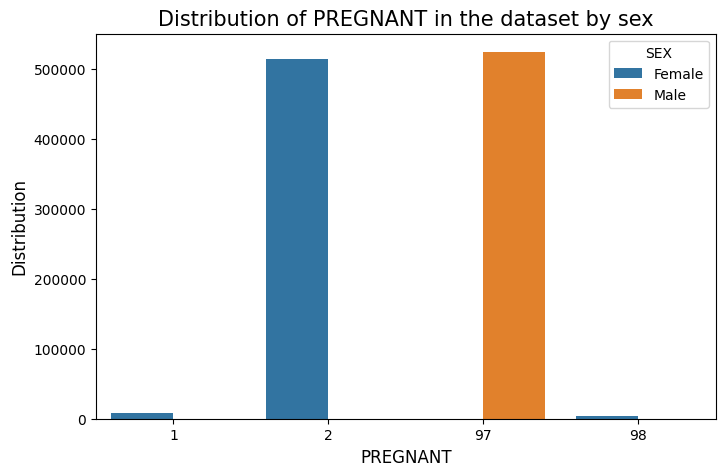

In [169]:
plt.figure(figsize = (8,5))
sns.countplot(x = df2['PREGNANT'], hue = df2['SEX'])
plt.xlabel('PREGNANT', fontsize = 12)
plt.ylabel('Distribution', fontsize = 12)
plt.title('Distribution of PREGNANT in the dataset by sex', fontsize = 15)
plt.show()

We see that PREGNANT value equals to 97 for every string for male sex. So every man has the value 97 in PREGNANT column due to the fact that men can't be pregnant. It means that we can replace this value by 0.
We see that when doctors don't have any info about women pregnancy they put 98 value to the PREGNANT column. I suppose that it is useful to handle this value (PREGNANT = 98) as NaN value.

In [170]:
import numpy as np
df2['PREGNANT'].replace({97 : 0, 98 : np.nan}, inplace = True)
df2.groupby(['SEX', 'PREGNANT'])['PREGNANT'].count()

SEX     PREGNANT
Female  1.0           8131
        2.0         513179
Male    0.0         523511
Name: PREGNANT, dtype: int64

The description of the dataset contains information telling us that when Boolean feature equals to "2" it means that the boolean value is "No".  Let's replace all them by "0" for all features to have more clear form of the dataset.

We should replace all '2.0' by '0' for all boolean columns (instead of DEATH):

In [171]:
df2.drop('AGE', axis = 1, inplace = True)
df2.drop('CLASIFFICATION_FINAL', axis = 1, inplace = True)
df2.drop('MEDICAL_UNIT', axis = 1, inplace = True)
df2.replace(2.0, 0, inplace=True)
df2['AGE'] = df['AGE']
df2['CLASIFFICATION_FINAL'] = df['CLASIFFICATION_FINAL']
df2['MEDICAL_UNIT'] = df['MEDICAL_UNIT']
df2.groupby(['SEX', 'PREGNANT'])['PREGNANT'].count()

SEX     PREGNANT
Female  0.0         513179
        1.0           8131
Male    0.0         523511
Name: PREGNANT, dtype: int64

Now SEX and PREGNANT columns are clear for understanding and ready for futher analysis.

In [172]:
df2.head()

,USMER,SEX,PATIENT_TYPE,DATE_DIED,INTUBED,PNEUMONIA,PREGNANT,DIABETES,COPD,ASTHMA,INMSUPR,HIPERTENSION,OTHER_DISEASE,CARDIOVASCULAR,OBESITY,RENAL_CHRONIC,TOBACCO,ICU,DEATH,AGE,CLASIFFICATION_FINAL,MEDICAL_UNIT
0,0,Female,1,03/05/2020,97,1,0.0,0,0,0,0,1,0,0,0,0,0,97,1,65,3,1
1,0,Male,1,03/06/2020,97,1,0.0,0,0,0,0,1,0,0,1,1,0,97,1,72,5,1
2,0,Male,0,09/06/2020,1,0,0.0,1,0,0,0,0,0,0,0,0,0,0,1,55,3,1
3,0,Female,1,12/06/2020,97,0,0.0,0,0,0,0,0,0,0,0,0,0,97,1,53,7,1
4,0,Male,1,21/06/2020,97,0,0.0,1,0,0,0,1,0,0,0,0,0,97,1,68,3,1


### Analysis of Nan variables:

Lets check how many null variables do we have for all features:

In [173]:
df3 = df2.copy()
df3.drop('AGE', axis = 1, inplace = True)
df3.replace([97, 98, 99], np.nan, inplace = True)
df3['AGE'] = df2['AGE']
df3.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1048575 entries, 0 to 1048574
Data columns (total 22 columns):
 #   Column                Non-Null Count    Dtype  
---  ------                --------------    -----  
 0   USMER                 1048575 non-null  int64  
 1   SEX                   1048575 non-null  object 
 2   PATIENT_TYPE          1048575 non-null  int64  
 3   DATE_DIED             1048575 non-null  object 
 4   INTUBED               192706 non-null   float64
 5   PNEUMONIA             1032572 non-null  float64
 6   PREGNANT              1044821 non-null  float64
 7   DIABETES              1045237 non-null  float64
 8   COPD                  1045572 non-null  float64
 9   ASTHMA                1045596 non-null  float64
 10  INMSUPR               1045171 non-null  float64
 11  HIPERTENSION          1045471 non-null  float64
 12  OTHER_DISEASE         1043530 non-null  float64
 13  CARDIOVASCULAR        1045499 non-null  float64
 14  OBESITY               1045543 non-

In [174]:
df3.isnull().sum()

USMER                        0
SEX                          0
PATIENT_TYPE                 0
DATE_DIED                    0
INTUBED                 855869
PNEUMONIA                16003
PREGNANT                  3754
DIABETES                  3338
COPD                      3003
ASTHMA                    2979
INMSUPR                   3404
HIPERTENSION              3104
OTHER_DISEASE             5045
CARDIOVASCULAR            3076
OBESITY                   3032
RENAL_CHRONIC             3006
TOBACCO                   3220
ICU                     856032
DEATH                        0
CLASIFFICATION_FINAL         0
MEDICAL_UNIT                 0
AGE                          0
dtype: int64

Some columns don't contain null variables.
We have 3000 - 16000 missing values for several classes and it doesn't look embarrassing for such huge dataset with more than 1 million observations. So we can drop observations with NaN values for these features.
The columns Intubed and ICU contain a lot off NaN variables so it's needed to study them better and decide how to handle these variables.
Lets check if we can replace them with 0 instead of Null or should we drop these columns.

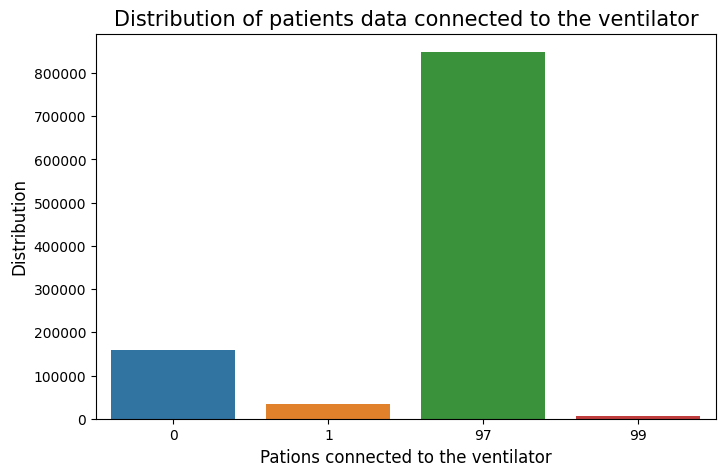

In [175]:
plt.figure(figsize = (8,5))
sns.countplot(x = df2['INTUBED'])
plt.xlabel('Pations connected to the ventilator', fontsize = 12)
plt.ylabel('Distribution', fontsize = 12)
plt.title('Distribution of patients data connected to the ventilator', fontsize = 15)
plt.show()

Let's look at PATIENT_TYPE column there value '1' means that the patient was returned home from a hospital.

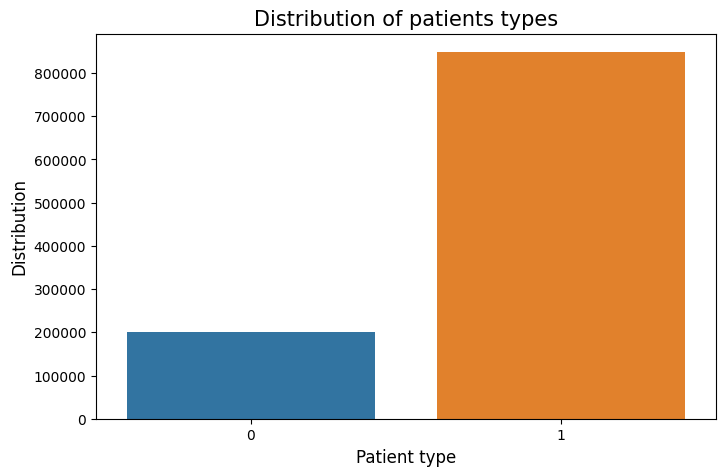

In [176]:
plt.figure(figsize = (8,5))
sns.countplot(x = df2['PATIENT_TYPE'])
plt.xlabel('Patient type', fontsize = 12)
plt.ylabel('Distribution', fontsize = 12)
plt.title('Distribution of patients types', fontsize = 15)
plt.show()

Let's perform an analysis of combined INTUBED and PATIENT_TYPE variables.

### Intubed

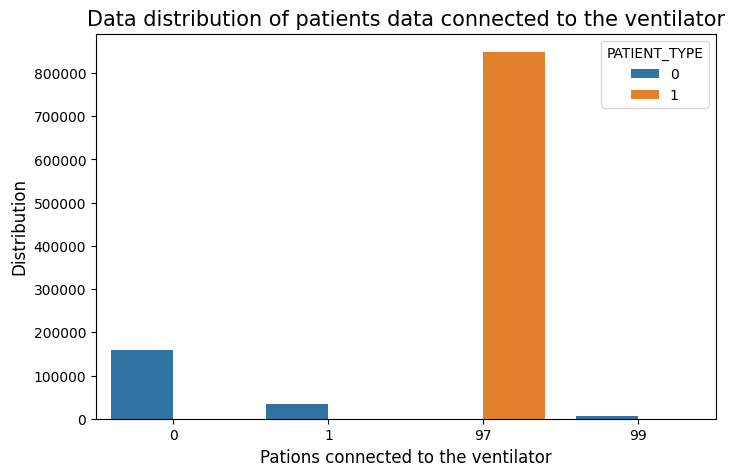

In [177]:
plt.figure(figsize = (8,5))
sns.countplot(x = df2['INTUBED'], hue = df2['PATIENT_TYPE'])
plt.xlabel('Pations connected to the ventilator', fontsize = 12)
plt.ylabel('Distribution', fontsize = 12)
plt.title('Data distribution of patients data connected to the ventilator', fontsize = 15)
plt.show()

In [178]:
df2.groupby(['INTUBED', 'PATIENT_TYPE'])['PATIENT_TYPE'].count()

INTUBED  PATIENT_TYPE
0        0               159050
1        0                33656
97       1               848544
99       0                 7325
Name: PATIENT_TYPE, dtype: int64

df2.groupby() proves the above distribution:

This distribution means that patients who were sent home from a hospital had value = 97 for INTUBED feature. It means that they couldn't be connected to the ventilator at home.
Value 99 for INTUBED column is missing value.

### ICU

Let's perform the same analysis for ICU feature:

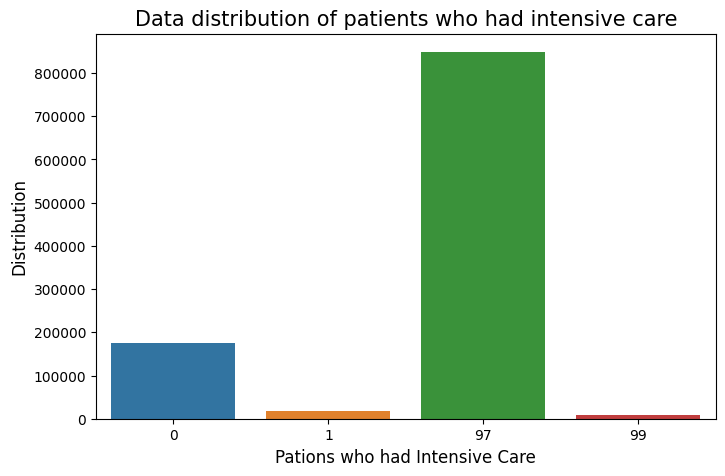

In [179]:
plt.figure(figsize = (8,5))
sns.countplot(x = df2['ICU'])
plt.xlabel('Pations who had Intensive Care', fontsize = 12)
plt.ylabel('Distribution', fontsize = 12)
plt.title('Data distribution of patients who had intensive care', fontsize = 15)
plt.show()

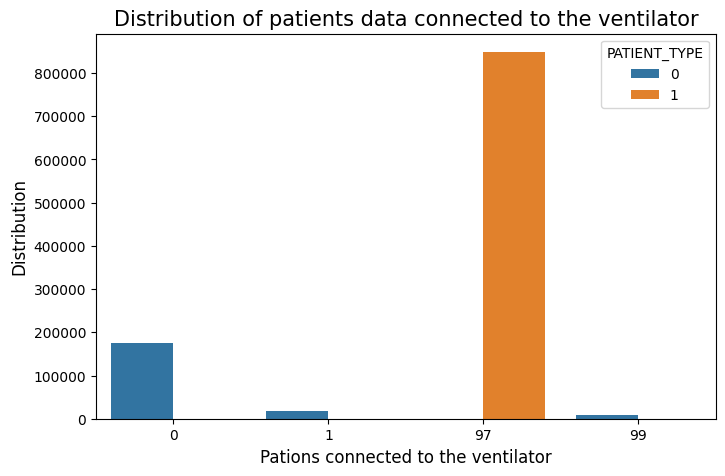

In [180]:
plt.figure(figsize = (8,5))
sns.countplot(x = df2['ICU'], hue = df2['PATIENT_TYPE'])
plt.xlabel('Pations connected to the ventilator', fontsize = 12)
plt.ylabel('Distribution', fontsize = 12)
plt.title('Distribution of patients data connected to the ventilator', fontsize = 15)
plt.show()

We have the same distribution for ICU!
Value 97 means that the patient was sent home from a hospital and didn't have an ICU. Value 99 is a missing value.

### Classification final

Lets look at CLASIFFICATION_FINAL column and its desription provided by the dataset creator:

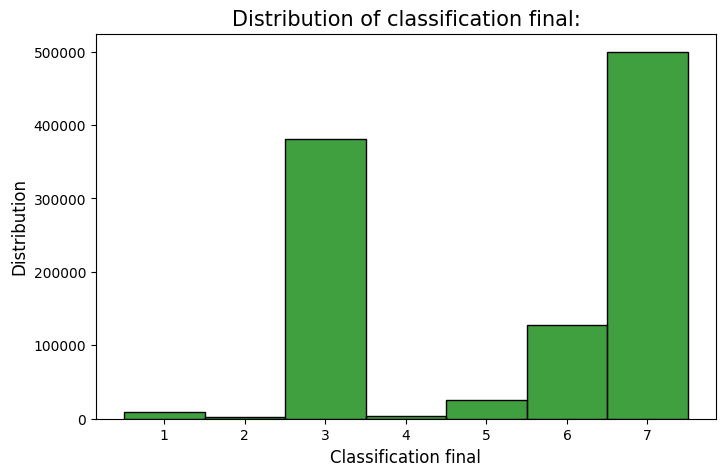

In [181]:
plt.figure(figsize = (8,5))
sns.histplot(x = df2['CLASIFFICATION_FINAL'], discrete = True, color = 'green')
plt.xlabel('Classification final', fontsize = 12)
plt.ylabel('Distribution', fontsize = 12)
plt.title('Distribution of classification final:', fontsize = 15)
plt.show()

The feature description:
classification_final: covid test findings. Values 1-3 mean that the patient was diagnosed with covid in different degrees. 4 or higher means that the patient is not a carrier of covid or that the test is inconclusive.
This description means that it is possible to encode this column as a boolean feature. Value "1" is sutable when classification result is 1 - 3. The value "0" is sutable when classification result is 4 - 7.
For the begining let's try to use the original values we can replace them by boolean later to check the results.
And it's better to change the name of this column and to call it TEST_RESULT.

Let's look at several other feature distributions:

All the rest features have only one value (99 for pneumonia and 98 for the rest) written as missing value (see df.value_counts())

### Tobacco

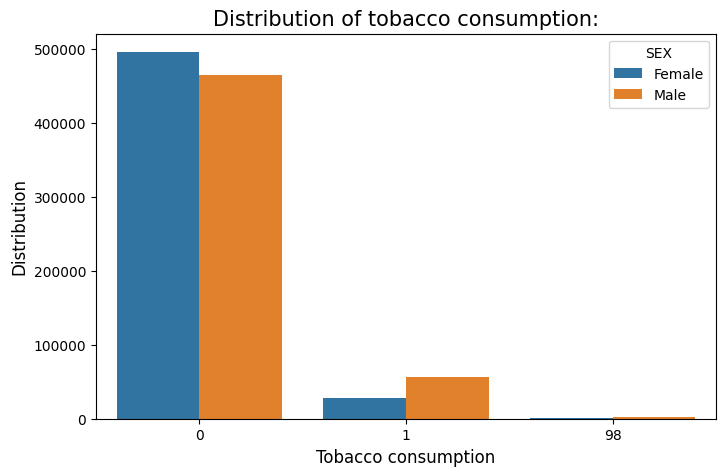

In [182]:
plt.figure(figsize = (8,5))
sns.countplot(x = df2['TOBACCO'], hue = df2['SEX'])
plt.xlabel('Tobacco consumption', fontsize = 12)
plt.ylabel('Distribution', fontsize = 12)
plt.title('Distribution of tobacco consumption:', fontsize = 15)
plt.show()

98 here is a missing value.

### Obesity

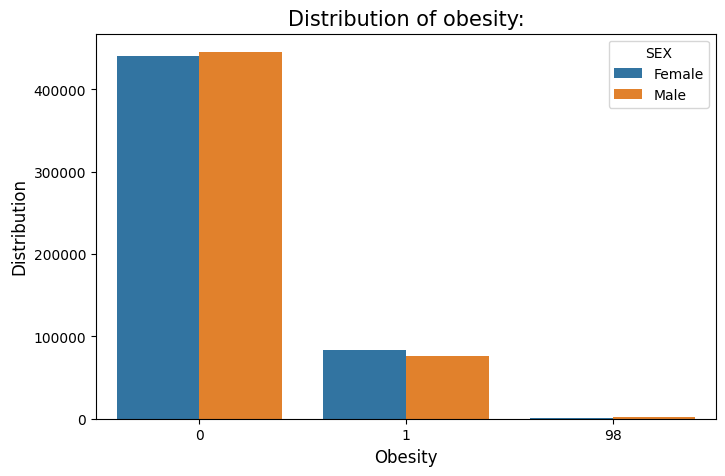

In [183]:
plt.figure(figsize = (8,5))
sns.countplot(x = df2['OBESITY'], hue = df2['SEX'])
plt.xlabel('Obesity', fontsize = 12)
plt.ylabel('Distribution', fontsize = 12)
plt.title('Distribution of obesity:', fontsize = 15)
plt.show()

98 here is missing value as well

### Pneumonia

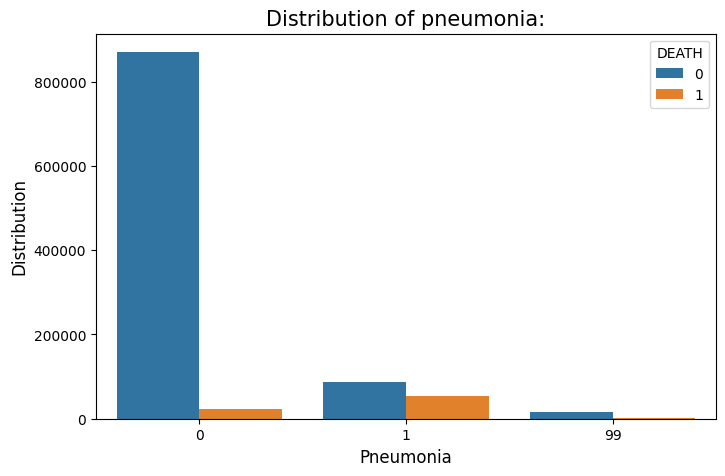

In [184]:
plt.figure(figsize = (8,5))
sns.countplot(x = df2['PNEUMONIA'], hue = df2['DEATH'])
plt.xlabel('Pneumonia', fontsize = 12)
plt.ylabel('Distribution', fontsize = 12)
plt.title('Distribution of pneumonia:', fontsize = 15)
plt.show()

For PNEUMONIA 99 is missing value

We can consider values which equal to 99 or 98 in these columns as missing values (see df.value_counts() function).

### AGE

Lets perform feature enginnering for AGE variable:

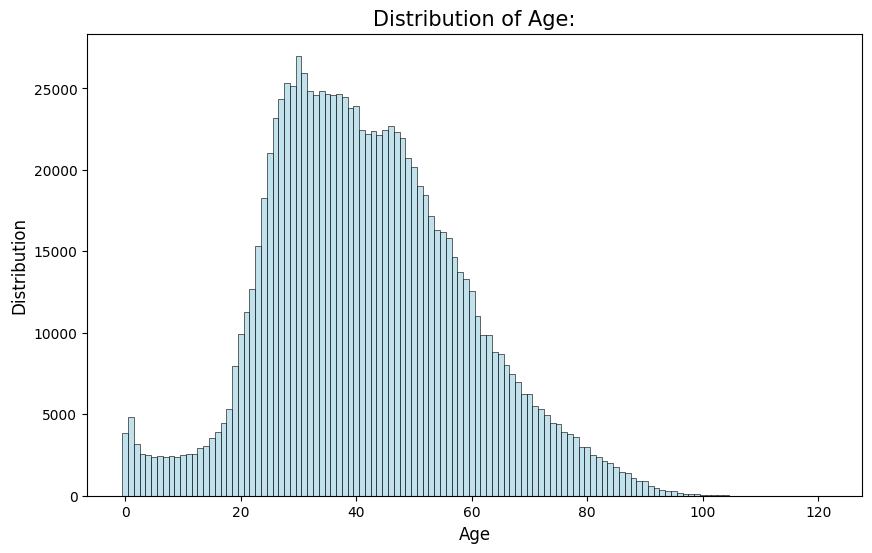

In [185]:
plt.figure(figsize = (10,6))
sns.histplot(x = df2['AGE'], discrete = True, color = 'lightblue')
plt.xlabel('Age', fontsize = 12)
plt.ylabel('Distribution', fontsize = 12)
plt.title('Distribution of Age:', fontsize = 15)
plt.show()

In [186]:
df2['AGE'].min()

0

In [187]:
df2['AGE'].max()

121

I suppose that for proper model building for this dataset we need to divide age variable by decades and perform one hot encoding for it. After this division we will be able to analyze death risk of Covid disease for people of different ages.

In [188]:
df2['AGE'].replace([0,1,2,3,4,5,6,7,8,9], 'AGE_0-9', inplace = True)
df2['AGE'].replace([10,11,12,13,14,15,16,17,18,19], 'AGE_10-19', inplace = True)
df2['AGE'].replace([20,21,22,23,24,25,26,27,28,29], 'AGE_20-29', inplace = True)
df2['AGE'].replace([30,31,32,33,34,35,36,37,38,39], 'AGE_30-39', inplace = True)
df2['AGE'].replace([40,41,42,43,44,45,46,47,48,49], 'AGE_40-49', inplace = True)
df2['AGE'].replace([50,51,52,53,54,55,56,57,58,59], 'AGE_50-59', inplace = True)
df2['AGE'].replace([60,61,62,63,64,65,66,67,68,69], 'AGE_60-69', inplace = True)
df2['AGE'].replace([70,71,72,73,74,75,76,77,78,79], 'AGE_70-79', inplace = True)
df2['AGE'].replace([80,81,82,83,84,85,86,87,88,89], 'AGE_80-89', inplace = True)
df2['AGE'].replace(list(range(90, 122)), 'AGE_OVER_90', inplace = True)

In [189]:
df2['AGE'].value_counts(normalize = True)

AGE_30-39      0.237869
AGE_40-49      0.212973
AGE_20-29      0.177861
AGE_50-59      0.157092
AGE_60-69      0.085369
AGE_70-79      0.043032
AGE_10-19      0.037000
AGE_0-9        0.027541
AGE_80-89      0.017807
AGE_OVER_90    0.003455
Name: AGE, dtype: float64

In [190]:
df2.head()

,USMER,SEX,PATIENT_TYPE,DATE_DIED,INTUBED,PNEUMONIA,PREGNANT,DIABETES,COPD,ASTHMA,INMSUPR,HIPERTENSION,OTHER_DISEASE,CARDIOVASCULAR,OBESITY,RENAL_CHRONIC,TOBACCO,ICU,DEATH,AGE,CLASIFFICATION_FINAL,MEDICAL_UNIT
0,0,Female,1,03/05/2020,97,1,0.0,0,0,0,0,1,0,0,0,0,0,97,1,AGE_60-69,3,1
1,0,Male,1,03/06/2020,97,1,0.0,0,0,0,0,1,0,0,1,1,0,97,1,AGE_70-79,5,1
2,0,Male,0,09/06/2020,1,0,0.0,1,0,0,0,0,0,0,0,0,0,0,1,AGE_50-59,3,1
3,0,Female,1,12/06/2020,97,0,0.0,0,0,0,0,0,0,0,0,0,0,97,1,AGE_50-59,7,1
4,0,Male,1,21/06/2020,97,0,0.0,1,0,0,0,1,0,0,0,0,0,97,1,AGE_60-69,3,1


In [191]:
dum_df = pd.get_dummies(df2['AGE'])
df2 = pd.concat([df2, dum_df], axis = 1)
df2.head()

,USMER,SEX,PATIENT_TYPE,DATE_DIED,INTUBED,PNEUMONIA,PREGNANT,DIABETES,COPD,ASTHMA,INMSUPR,HIPERTENSION,OTHER_DISEASE,CARDIOVASCULAR,OBESITY,RENAL_CHRONIC,TOBACCO,ICU,DEATH,AGE,CLASIFFICATION_FINAL,MEDICAL_UNIT,AGE_0-9,AGE_10-19,AGE_20-29,AGE_30-39,AGE_40-49,AGE_50-59,AGE_60-69,AGE_70-79,AGE_80-89,AGE_OVER_90
0,0,Female,1,03/05/2020,97,1,0.0,0,0,0,0,1,0,0,0,0,0,97,1,AGE_60-69,3,1,0,0,0,0,0,0,1,0,0,0
1,0,Male,1,03/06/2020,97,1,0.0,0,0,0,0,1,0,0,1,1,0,97,1,AGE_70-79,5,1,0,0,0,0,0,0,0,1,0,0
2,0,Male,0,09/06/2020,1,0,0.0,1,0,0,0,0,0,0,0,0,0,0,1,AGE_50-59,3,1,0,0,0,0,0,1,0,0,0,0
3,0,Female,1,12/06/2020,97,0,0.0,0,0,0,0,0,0,0,0,0,0,97,1,AGE_50-59,7,1,0,0,0,0,0,1,0,0,0,0
4,0,Male,1,21/06/2020,97,0,0.0,1,0,0,0,1,0,0,0,0,0,97,1,AGE_60-69,3,1,0,0,0,0,0,0,1,0,0,0


### Medical Unit

Let's analyze the final one feature - medical unit:

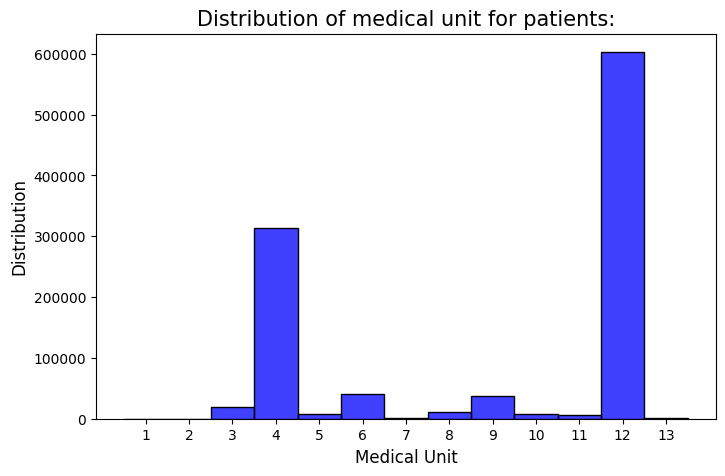

In [192]:
plt.figure(figsize = (8,5))
sns.histplot(x = df2['MEDICAL_UNIT'], discrete = True, color = 'blue')
plt.xlabel('Medical Unit', fontsize = 12)
plt.ylabel('Distribution', fontsize = 12)
plt.title('Distribution of medical unit for patients:', fontsize = 15)
plt.xticks(range(1, 14, 1))
plt.show()

Due to the fact that it is an ordinal variable providing us information about medical distribution without additional description I supposes that the best way is to remove this variable from the dataset for the model building stage.

Now we can analyze the dataset more carefully.

At the first it's neccesary to drop all the rows with missing values for the columns:
PNEUMONIA
PREGNANT
DIABETES
COPD
ASTHMA
INMSUPR
HIPERTENSION
OTHER_DISEASE
CARDIOVASCULAR
OBESITY
RENAL_CHRONIC
TOBACCO
ICU
INTUBED

In [193]:
df2['ICU'].replace(97, 0, inplace=True)
df2['INTUBED'].replace(97, 0, inplace = True)

In [194]:
df2['ICU'].value_counts(normalize = True)

0     0.976782
1     0.016077
99    0.007141
Name: ICU, dtype: float64

In [195]:
df2['INTUBED'].value_counts(normalize = True)

0     0.960917
1     0.032097
99    0.006986
Name: INTUBED, dtype: float64

Now these columns are cleaned and we may continue the dataset handling.

In [196]:
df2.head(10)

,USMER,SEX,PATIENT_TYPE,DATE_DIED,INTUBED,PNEUMONIA,PREGNANT,DIABETES,COPD,ASTHMA,INMSUPR,HIPERTENSION,OTHER_DISEASE,CARDIOVASCULAR,OBESITY,RENAL_CHRONIC,TOBACCO,ICU,DEATH,AGE,CLASIFFICATION_FINAL,MEDICAL_UNIT,AGE_0-9,AGE_10-19,AGE_20-29,AGE_30-39,AGE_40-49,AGE_50-59,AGE_60-69,AGE_70-79,AGE_80-89,AGE_OVER_90
0,0,Female,1,03/05/2020,0,1,0.0,0,0,0,0,1,0,0,0,0,0,0,1,AGE_60-69,3,1,0,0,0,0,0,0,1,0,0,0
1,0,Male,1,03/06/2020,0,1,0.0,0,0,0,0,1,0,0,1,1,0,0,1,AGE_70-79,5,1,0,0,0,0,0,0,0,1,0,0
2,0,Male,0,09/06/2020,1,0,0.0,1,0,0,0,0,0,0,0,0,0,0,1,AGE_50-59,3,1,0,0,0,0,0,1,0,0,0,0
3,0,Female,1,12/06/2020,0,0,0.0,0,0,0,0,0,0,0,0,0,0,0,1,AGE_50-59,7,1,0,0,0,0,0,1,0,0,0,0
4,0,Male,1,21/06/2020,0,0,0.0,1,0,0,0,1,0,0,0,0,0,0,1,AGE_60-69,3,1,0,0,0,0,0,0,1,0,0,0
5,0,Female,0,9999-99-99,0,1,0.0,0,0,0,0,0,0,0,0,0,0,0,0,AGE_40-49,3,1,0,0,0,0,1,0,0,0,0,0
6,0,Female,1,9999-99-99,0,0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,AGE_60-69,3,1,0,0,0,0,0,0,1,0,0,0
7,0,Female,1,9999-99-99,0,1,0.0,1,0,0,1,1,0,0,0,1,0,0,0,AGE_60-69,3,1,0,0,0,0,0,0,1,0,0,0
8,0,Female,0,9999-99-99,0,0,0.0,1,0,0,0,1,0,0,1,0,0,0,0,AGE_30-39,3,1,0,0,0,1,0,0,0,0,0,0
9,0,Female,0,9999-99-99,0,0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,AGE_20-29,3,1,0,0,1,0,0,0,0,0,0,0


In [197]:
print(' ')
for i in list(df2.columns):
    print(df2[[i]].value_counts(normalize = True))
    print('--------------------------------------')
    print(' ')

USMER
0        0.632194
1        0.367806
dtype: float64
--------------------------------------
 
SEX   
Female    0.500741
Male      0.499259
dtype: float64
--------------------------------------
 
PATIENT_TYPE
1               0.809235
0               0.190765
dtype: float64
--------------------------------------
 
DATE_DIED 
9999-99-99    9.266223e-01
06/07/2020    9.536752e-04
07/07/2020    9.498605e-04
13/07/2020    9.441385e-04
16/06/2020    9.336480e-04
                  ...     
19/01/2021    9.536752e-07
18/10/2020    9.536752e-07
17/12/2020    9.536752e-07
17/10/2020    9.536752e-07
16/10/2020    9.536752e-07
Length: 401, dtype: float64
--------------------------------------
 
INTUBED
0          0.960917
1          0.032097
99         0.006986
dtype: float64
--------------------------------------
 
PNEUMONIA
0            0.851188
1            0.133551
99           0.015262
dtype: float64
--------------------------------------
 
PREGNANT
0.0         0.992218
1.0         0.00778

# Feature engineering

Lets create the dataframe which allows us to perform proper ML modelling.

In [198]:
df4 = df2.copy()

df4.drop('AGE', axis = 1, inplace = True)
df4.drop('DATE_DIED', axis = 1, inplace = True)
df4.drop('MEDICAL_UNIT', axis = 1, inplace = True)
df4['CLASIFFICATION_FINAL'].replace({1:1, 2:1, 3:1, 4:0, 5:0, 6:0, 7:0}, inplace = True)

df4.replace([98, 99], np.nan, inplace = True)
df4.dropna(axis = 0, inplace = True)

df4.rename(columns = {'CLASIFFICATION_FINAL':'TEST_RESULT', 'PATIENT_TYPE':'RETURNED_HOME'}, inplace = True)


df4.head()

,USMER,SEX,RETURNED_HOME,INTUBED,PNEUMONIA,PREGNANT,DIABETES,COPD,ASTHMA,INMSUPR,HIPERTENSION,OTHER_DISEASE,CARDIOVASCULAR,OBESITY,RENAL_CHRONIC,TOBACCO,ICU,DEATH,TEST_RESULT,AGE_0-9,AGE_10-19,AGE_20-29,AGE_30-39,AGE_40-49,AGE_50-59,AGE_60-69,AGE_70-79,AGE_80-89,AGE_OVER_90
0,0,Female,1,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1,1,0,0,0,0,0,0,1,0,0,0
1,0,Male,1,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1,0,0,0,0,0,0,0,0,1,0,0
2,0,Male,0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,1,0,0,0,0,0,1,0,0,0,0
3,0,Female,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0,0,0,0,0,0,1,0,0,0,0
4,0,Male,1,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1,1,0,0,0,0,0,0,1,0,0,0


The description of the dataset:

In [199]:
df4.describe()

,USMER,RETURNED_HOME,INTUBED,PNEUMONIA,PREGNANT,DIABETES,COPD,ASTHMA,INMSUPR,HIPERTENSION,OTHER_DISEASE,CARDIOVASCULAR,OBESITY,RENAL_CHRONIC,TOBACCO,ICU,DEATH,TEST_RESULT,AGE_0-9,AGE_10-19,AGE_20-29,AGE_30-39,AGE_40-49,AGE_50-59,AGE_60-69,AGE_70-79,AGE_80-89,AGE_OVER_90
count,1.019666e+06,1.019666e+06,1.019666e+06,1.019666e+06,1.019666e+06,1.019666e+06,1.019666e+06,1.019666e+06,1.019666e+06,1.019666e+06,1.019666e+06,1.019666e+06,1.019666e+06,1.019666e+06,1.019666e+06,1.019666e+06,1.019666e+06,1.019666e+06,1.019666e+06,1.019666e+06,1.019666e+06,1.019666e+06,1.019666e+06,1.019666e+06,1.019666e+06,1.019666e+06,1.019666e+06,1.019666e+06
mean,3.575583e-01,8.143696e-01,3.230077e-02,1.337811e-01,7.677024e-03,1.191851e-01,1.399282e-02,2.974405e-02,1.326219e-02,1.554028e-01,2.647534e-02,1.960348e-02,1.530423e-01,1.786860e-02,8.077057e-02,1.609154e-02,7.189609e-02,3.786534e-01,2.479930e-02,3.597943e-02,1.787389e-01,2.397687e-01,2.144173e-01,1.576369e-01,8.518378e-02,4.274439e-02,1.742139e-02,3.309907e-03
std,4.792813e-01,3.888083e-01,1.767978e-01,3.404171e-01,8.728170e-02,3.240064e-01,1.174608e-01,1.698805e-01,1.143954e-01,3.622885e-01,1.605441e-01,1.386333e-01,3.600284e-01,1.324739e-01,2.724826e-01,1.258277e-01,2.583159e-01,4.850518e-01,1.555131e-01,1.862389e-01,3.831337e-01,4.269424e-01,4.104177e-01,3.644004e-01,2.791551e-01,2.022804e-01,1.308354e-01,5.743653e-02
min,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,0.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,0.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
75%,1.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
max,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00


All integer variables have values "0" and "1" so it's possible to consider them as boolean.

In [200]:

data.drop("USMER", inplace=True, axis=1)

KeyError: "['USMER'] not found in axis"

In [ ]:
data = df4.copy()
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1019666 entries, 0 to 1048574
Data columns (total 29 columns):
 #   Column          Non-Null Count    Dtype  
---  ------          --------------    -----  
 0   USMER           1019666 non-null  int64  
 1   SEX             1019666 non-null  object 
 2   RETURNED_HOME   1019666 non-null  int64  
 3   INTUBED         1019666 non-null  float64
 4   PNEUMONIA       1019666 non-null  float64
 5   PREGNANT        1019666 non-null  float64
 6   DIABETES        1019666 non-null  float64
 7   COPD            1019666 non-null  float64
 8   ASTHMA          1019666 non-null  float64
 9   INMSUPR         1019666 non-null  float64
 10  HIPERTENSION    1019666 non-null  float64
 11  OTHER_DISEASE   1019666 non-null  float64
 12  CARDIOVASCULAR  1019666 non-null  float64
 13  OBESITY         1019666 non-null  float64
 14  RENAL_CHRONIC   1019666 non-null  float64
 15  TOBACCO         1019666 non-null  float64
 16  ICU             1019666 non-null  fl

In [ ]:
data.isnull().sum()

USMER             0
SEX               0
RETURNED_HOME     0
INTUBED           0
PNEUMONIA         0
PREGNANT          0
DIABETES          0
COPD              0
ASTHMA            0
INMSUPR           0
HIPERTENSION      0
OTHER_DISEASE     0
CARDIOVASCULAR    0
OBESITY           0
RENAL_CHRONIC     0
TOBACCO           0
ICU               0
DEATH             0
TEST_RESULT       0
AGE_0-9           0
AGE_10-19         0
AGE_20-29         0
AGE_30-39         0
AGE_40-49         0
AGE_50-59         0
AGE_60-69         0
AGE_70-79         0
AGE_80-89         0
AGE_OVER_90       0
dtype: int64

Now we don't have null values.

In [ ]:
data.head(10)

,USMER,SEX,RETURNED_HOME,INTUBED,PNEUMONIA,PREGNANT,DIABETES,COPD,ASTHMA,INMSUPR,HIPERTENSION,OTHER_DISEASE,CARDIOVASCULAR,OBESITY,RENAL_CHRONIC,TOBACCO,ICU,DEATH,TEST_RESULT,AGE_0-9,AGE_10-19,AGE_20-29,AGE_30-39,AGE_40-49,AGE_50-59,AGE_60-69,AGE_70-79,AGE_80-89,AGE_OVER_90
0,0,Female,1,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1,1,0,0,0,0,0,0,1,0,0,0
1,0,Male,1,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1,0,0,0,0,0,0,0,0,1,0,0
2,0,Male,0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,1,0,0,0,0,0,1,0,0,0,0
3,0,Female,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0,0,0,0,0,0,1,0,0,0,0
4,0,Male,1,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1,1,0,0,0,0,0,0,1,0,0,0
5,0,Female,0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,1,0,0,0,0,1,0,0,0,0,0
6,0,Female,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,1,0,0,0,0,0,0,1,0,0,0
7,0,Female,1,0.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0,1,0,0,0,0,0,0,1,0,0,0
8,0,Female,0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0,1,0,0,0,1,0,0,0,0,0,0
9,0,Female,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,1,0,0,1,0,0,0,0,0,0,0


Let's perform one-hot encoding for SEX variable:

In [ ]:
sex_dum = pd.get_dummies(data['SEX'])
data = pd.concat([data, sex_dum], axis = 1)
data.drop('SEX', axis = 1, inplace = True)
data.head(10)

,USMER,RETURNED_HOME,INTUBED,PNEUMONIA,PREGNANT,DIABETES,COPD,ASTHMA,INMSUPR,HIPERTENSION,OTHER_DISEASE,CARDIOVASCULAR,OBESITY,RENAL_CHRONIC,TOBACCO,ICU,DEATH,TEST_RESULT,AGE_0-9,AGE_10-19,AGE_20-29,AGE_30-39,AGE_40-49,AGE_50-59,AGE_60-69,AGE_70-79,AGE_80-89,AGE_OVER_90,Female,Male
0,0,1,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1,1,0,0,0,0,0,0,1,0,0,0,1,0
1,0,1,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1,0,0,0,0,0,0,0,0,1,0,0,0,1
2,0,0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,1,0,0,0,0,0,1,0,0,0,0,0,1
3,0,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0,0,0,0,0,0,1,0,0,0,0,1,0
4,0,1,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1,1,0,0,0,0,0,0,1,0,0,0,0,1
5,0,0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,1,0,0,0,0,1,0,0,0,0,0,1,0
6,0,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,1,0,0,0,0,0,0,1,0,0,0,1,0
7,0,1,0.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0,1,0,0,0,0,0,0,1,0,0,0,1,0
8,0,0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0,1,0,0,0,1,0,0,0,0,0,0,1,0
9,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,1,0,0,1,0,0,0,0,0,0,0,1,0


It's possible to convert all variables as integer let's do it:

In [ ]:
data = data.astype('int')
data.head(10)

,USMER,RETURNED_HOME,INTUBED,PNEUMONIA,PREGNANT,DIABETES,COPD,ASTHMA,INMSUPR,HIPERTENSION,OTHER_DISEASE,CARDIOVASCULAR,OBESITY,RENAL_CHRONIC,TOBACCO,ICU,DEATH,TEST_RESULT,AGE_0-9,AGE_10-19,AGE_20-29,AGE_30-39,AGE_40-49,AGE_50-59,AGE_60-69,AGE_70-79,AGE_80-89,AGE_OVER_90,Female,Male
0,0,1,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1,1,0,0,0,0,0,0,1,0,0,0,1,0
1,0,1,0,1,0,0,0,0,0,1,0,0,1,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1
2,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,1,0,0,0,0,0,1
3,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0
4,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,1,1,0,0,0,0,0,0,1,0,0,0,0,1
5,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0
6,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,1,0
7,0,1,0,1,0,1,0,0,1,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,1,0
8,0,0,0,0,0,1,0,0,0,1,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0
9,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0


In [ ]:
data.rename(columns = {'Female':'WOMAN', 'Male':'MAN'}, inplace = True)
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1019666 entries, 0 to 1048574
Data columns (total 30 columns):
 #   Column          Non-Null Count    Dtype
---  ------          --------------    -----
 0   USMER           1019666 non-null  int32
 1   RETURNED_HOME   1019666 non-null  int32
 2   INTUBED         1019666 non-null  int32
 3   PNEUMONIA       1019666 non-null  int32
 4   PREGNANT        1019666 non-null  int32
 5   DIABETES        1019666 non-null  int32
 6   COPD            1019666 non-null  int32
 7   ASTHMA          1019666 non-null  int32
 8   INMSUPR         1019666 non-null  int32
 9   HIPERTENSION    1019666 non-null  int32
 10  OTHER_DISEASE   1019666 non-null  int32
 11  CARDIOVASCULAR  1019666 non-null  int32
 12  OBESITY         1019666 non-null  int32
 13  RENAL_CHRONIC   1019666 non-null  int32
 14  TOBACCO         1019666 non-null  int32
 15  ICU             1019666 non-null  int32
 16  DEATH           1019666 non-null  int32
 17  TEST_RESULT     1019666 non

The data is fully ready for modelling now!

In [ ]:
data.to_csv('Covid_cleaned_Reg1.csv')

# Model building:

In [ ]:
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn

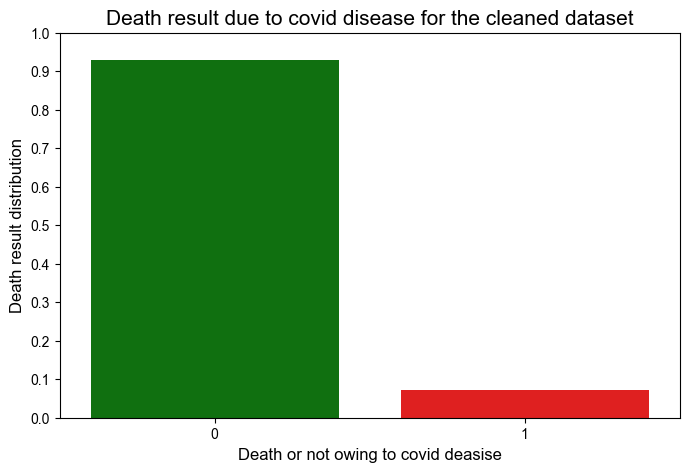

In [ ]:
death_dist = data.DEATH.value_counts(normalize = True)
plt.figure(figsize = (8,5))
sns.barplot(x = death_dist.index, y = death_dist.values,
            palette = ['green', 'red'])
plt.xlabel('Death or not owing to covid deasise', fontsize = 12)
plt.ylabel('Death result distribution', fontsize = 12)
plt.title('Death result due to covid disease for the cleaned dataset', fontsize = 15)
plt.yticks(np.arange(0, 1.1, 0.1))
sns.set_style('whitegrid')
plt.show()

The cleaned dataset has variable distribution which is close to 10:1 proportion. I would like to use undersampling to balance the dataset before model training.

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1019666 entries, 0 to 1048574
Data columns (total 30 columns):
 #   Column          Non-Null Count    Dtype
---  ------          --------------    -----
 0   USMER           1019666 non-null  int32
 1   RETURNED_HOME   1019666 non-null  int32
 2   INTUBED         1019666 non-null  int32
 3   PNEUMONIA       1019666 non-null  int32
 4   PREGNANT        1019666 non-null  int32
 5   DIABETES        1019666 non-null  int32
 6   COPD            1019666 non-null  int32
 7   ASTHMA          1019666 non-null  int32
 8   INMSUPR         1019666 non-null  int32
 9   HIPERTENSION    1019666 non-null  int32
 10  OTHER_DISEASE   1019666 non-null  int32
 11  CARDIOVASCULAR  1019666 non-null  int32
 12  OBESITY         1019666 non-null  int32
 13  RENAL_CHRONIC   1019666 non-null  int32
 14  TOBACCO         1019666 non-null  int32
 15  ICU             1019666 non-null  int32
 16  DEATH           1019666 non-null  int32
 17  TEST_RESULT     1019666 non

We have more than 1 million observations in the dataset.
For the begining lets extract training and testing sets before performing undersampling.

__It's essential to check model running results on data with original distribution! Not undersampled!__

In [ ]:
from sklearn.model_selection import train_test_split
X = data.drop('DEATH', axis = 1)
y = data['DEATH']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.05, stratify = y, random_state = 72)
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(968682, 29) (968682,)
(50984, 29) (50984,)


In [ ]:
from imblearn.under_sampling import RandomUnderSampler
X_under, y_under = RandomUnderSampler().fit_resample(X_train, y_train)
print(X_under.shape, y_under.shape)

(139288, 29) (139288,)


Now we have training undersampled dataset and testing dataset with original distribution.

### Logistic regression modelling

In [ ]:
from sklearn.linear_model import LogisticRegressionCV
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import GridSearchCV

# from sklearn.metrics import plot_confusion_matrix as plotCM
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score

Training of the model:

In [ ]:
estimator = LogisticRegression(penalty = 'l1', max_iter = 100000)

params = {
    'C':[0.01, 0.05, 0.1, 0.5, 1, 3, 5, 10],
    'solver':['liblinear', 'saga']
}
search = GridSearchCV(estimator = estimator, param_grid = params, scoring = 'f1', cv = 4)

In [ ]:
search.fit(X_under, y_under)
print("Best estimator:", search.best_estimator_)
print(' ')
print("Best params:", search.best_params_)
print(' ')
print("Best f1 score:", search.best_score_)

Best estimator: LogisticRegression(C=3, max_iter=100000, penalty='l1', solver='saga')
 
Best params: {'C': 3, 'solver': 'saga'}
 
Best f1 score: 0.906575055853992


### Results:

In [ ]:
y_hat = search.best_estimator_.predict(X_test)
print('Results of test set prediction analyzing:')
print(' ')
print('Classification report:')
print(classification_report(y_test, y_hat))
print(' ')
print('Accuracy of prediction:')
print(accuracy_score(y_test, y_hat))
print(' ')
print("roc-auc score")
print(roc_auc_score(y_test, y_hat))

Results of test set prediction analyzing:
 
Classification report:
              precision    recall  f1-score   support

           0       0.99      0.90      0.94     47318
           1       0.41      0.91      0.56      3666

    accuracy                           0.90     50984
   macro avg       0.70      0.90      0.75     50984
weighted avg       0.95      0.90      0.92     50984

 
Accuracy of prediction:
0.8990075317746744
 
roc-auc score
0.9036929265507208


Confusion matrix:

Text(0.5, 1.0, 'Confusion matrix for testing dataset')

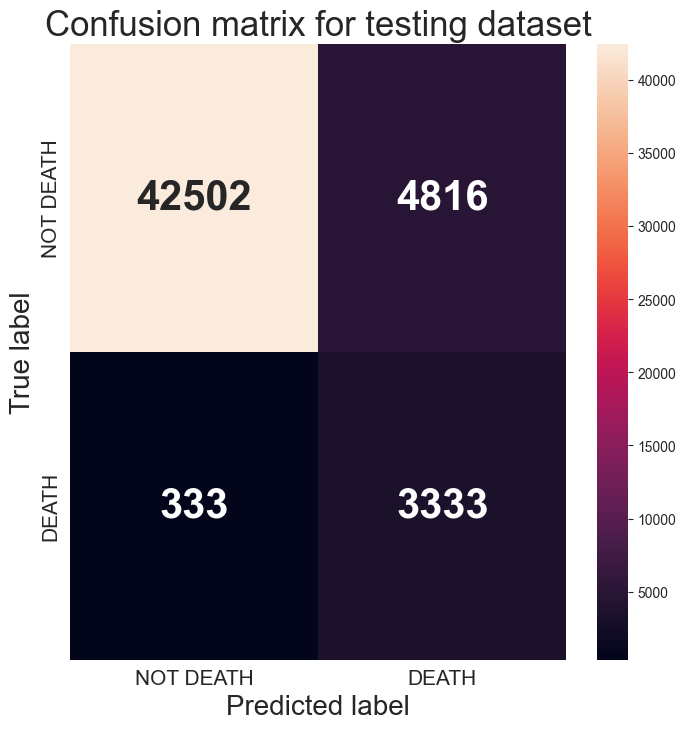

In [ ]:
_, ax = plt.subplots(figsize=(8,8))
ax = sns.heatmap(confusion_matrix(y_test, y_hat), annot=True, fmt='d', annot_kws={"size": 30, "weight": "bold"})
labels = ['NOT DEATH', 'DEATH']
ax.set_xticklabels(labels, fontsize=15)
ax.set_yticklabels(labels, fontsize=15)
ax.set_ylabel('True label', fontsize=20)
ax.set_xlabel('Predicted label', fontsize=20)
ax.set_title('Confusion matrix for testing dataset', fontsize = 25)

Lets analyze the results:
1. We make predictions for disease results so it's essential to predict minimal quantity of False negative results with high recall to understand dangerous factors which may lead to death. For such task it's better to overestimate risks to understand them better.
2. The model has high recall for "1" class = 0.91 with low precision = 0.41 and avg f1 score = 0.92 for both classes. These results look well for the dataset see point 1.
3. ROC_AUC score equals to 0.904 This result looks pretty good.
4. We have strongly imballeced dataset so high accuracy rate (accuracy = 0.9) doesn't make any sense.
5. For such strongly imbalanced dataset it's better to estimate the model by f1 metric than by ROC-AUC.

# Model interpretation:

Now it's time to interpret the model results and to estimate them.

For the start let's prepare the features of the plot:

In [ ]:
column_list = X.columns.to_list()
column_list

['USMER',
 'RETURNED_HOME',
 'INTUBED',
 'PNEUMONIA',
 'PREGNANT',
 'DIABETES',
 'COPD',
 'ASTHMA',
 'INMSUPR',
 'HIPERTENSION',
 'OTHER_DISEASE',
 'CARDIOVASCULAR',
 'OBESITY',
 'RENAL_CHRONIC',
 'TOBACCO',
 'ICU',
 'TEST_RESULT',
 'AGE_0-9',
 'AGE_10-19',
 'AGE_20-29',
 'AGE_30-39',
 'AGE_40-49',
 'AGE_50-59',
 'AGE_60-69',
 'AGE_70-79',
 'AGE_80-89',
 'AGE_OVER_90',
 'WOMAN',
 'MAN']

In [ ]:
search.best_estimator_.coef_

array([[ 0.14680128, -2.54646681,  2.45280469,  1.35643286, -0.44588521,
         0.39596674,  0.04134663, -0.21735899,  0.45536977,  0.11521982,
         0.54339559, -0.05411196,  0.26982886,  0.83180996, -0.20940179,
        -0.35357057,  0.82939056, -1.35103216, -1.69925382, -1.48262165,
        -1.03060004, -0.41835101,  0.21539674,  0.84563887,  1.30897358,
         1.59858499,  1.76739311, -0.38248214,  0.14394407]])

Functions provided by IBM in their courses to interpret Logistic Regression models:

In [ ]:
def get_feature_coefs(regression_model, columns):
    coef_dict = {}
    for coef, feat in zip(regression_model.coef_[0], columns):
        coef_dict[feat] = coef
    # Sort coefficients
    coef_dict = {k: v for k, v in sorted(coef_dict.items(), key=lambda item: item[1])}
    return coef_dict

# Generate bar colors based on if value is negative or positive
def get_bar_colors(values):
    color_vals = []
    for val in values:
        if val <= 0:
            color_vals.append('g')
        else:
            color_vals.append('r')
    return color_vals

# Visualize coefficients
def visualize_coefs(coef_dict):
    features = list(coef_dict.keys())
    values = list(coef_dict.values())
    y_pos = np.arange(len(features))
    color_vals = get_bar_colors(values)
    plt.rcdefaults()
    fig, ax = plt.subplots(figsize=(8,8))
    ax.barh(y_pos, values, align='center', color=color_vals)
    ax.set_yticks(y_pos)
    ax.set_yticklabels(features, fontsize = 10)
    # labels read top-to-bottom
    ax.invert_yaxis()
    ax.set_xlabel('Feature Coefficients')
    ax.set_title('')
    plt.show()

In [ ]:
coef_dict = get_feature_coefs(search.best_estimator_, column_list)
coef_dict

{'RETURNED_HOME': -2.5464668068406966,
 'AGE_10-19': -1.699253819064812,
 'AGE_20-29': -1.4826216503752636,
 'AGE_0-9': -1.35103216165071,
 'AGE_30-39': -1.0306000385145482,
 'PREGNANT': -0.4458852065091152,
 'AGE_40-49': -0.4183510065094432,
 'WOMAN': -0.3824821392402764,
 'ICU': -0.353570572721133,
 'ASTHMA': -0.21735899205292447,
 'TOBACCO': -0.20940179400549339,
 'CARDIOVASCULAR': -0.05411195833421286,
 'COPD': 0.04134663187532799,
 'HIPERTENSION': 0.11521981677224671,
 'MAN': 0.14394406699908854,
 'USMER': 0.1468012763429627,
 'AGE_50-59': 0.21539673887196964,
 'OBESITY': 0.26982885613095525,
 'DIABETES': 0.39596673905027924,
 'INMSUPR': 0.45536977248062394,
 'OTHER_DISEASE': 0.5433955912627321,
 'TEST_RESULT': 0.8293905572000314,
 'RENAL_CHRONIC': 0.8318099593912135,
 'AGE_60-69': 0.8456388696536752,
 'AGE_70-79': 1.3089735806079887,
 'PNEUMONIA': 1.3564328553335998,
 'AGE_80-89': 1.5985849863361516,
 'AGE_OVER_90': 1.7673931090969455,
 'INTUBED': 2.452804688168842}

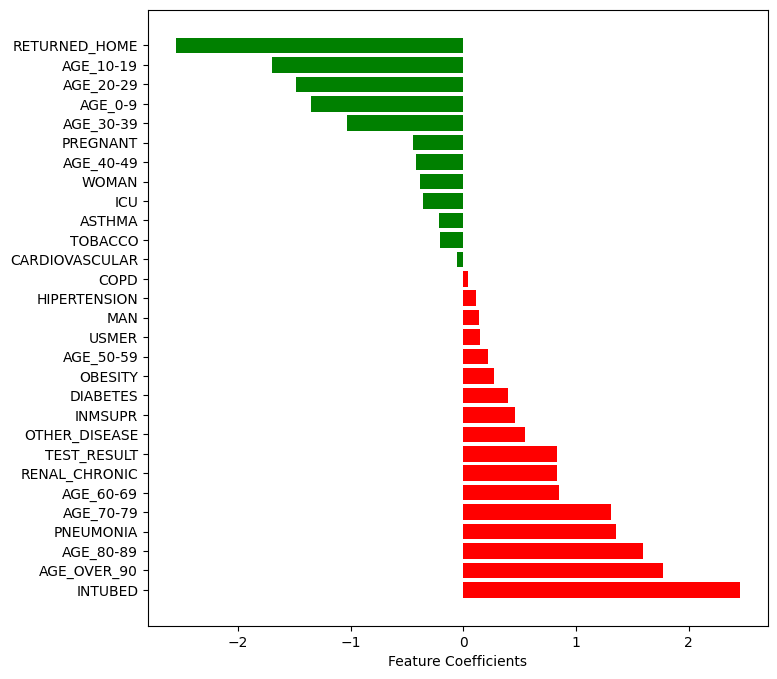

In [ ]:
visualize_coefs(coef_dict)

# Conclusions:

We see that the most dangerous health factors (red zone) are:
1. Age: The older the patient the higher is risk of death. We see high risks for patients over 60 (Logistic regression coefficient is bigger than 1). They are all in red zone with negative age influence.
2. INTUBED: This feature means that the patients connected to the ventilator have very high risk of death.
3. Pneumonia: One of covid disease symptoms. If the patient get pneumonia due to Covid infection he is in risk zone.
4. Patients with renal chronic problems, diabet, other chronic diseases and immunosuppressed patients (mostly men as we see it at the barplot) are in risk zone but coefficients for such chronic problems are less than 1 so these factors are less significant than pneumonia symptom and age(a lot of chronic diseases depend on age, persons who are older usually have such diseases).
5. Patients who have positive test result are in red zone so doctors should pay attention to them.

The most important _positive_ factors (green zone) are:
1. RETURNED_HOME - If patient was returned home from a hospital it means that he hadn't got heavy symptoms which could lead to death.
2. Yong age - Patients with age less than 50 have less chances to die owing to covid infection.
3. Women have more rare death result then men.
4. Pregnant weman have low risk of death outcome (I suppose it's correlated with age of women. Women in risk zone are old women who have pregnancy very rare).
5. We see little positive effect of ICU - it means that patients who had ICU (the patient had been admitted to an Intensive Care Unit) and weren't connected to a ventilator had good chances to get good illness outcome and to stay alive.

# Model Building DTree classifier:

Lets train a decision tree classifier and check how it will make predictions for the dataset:

In [ ]:
from sklearn.tree import DecisionTreeClassifier as Dtree

Model building:

In [ ]:
estimator = Dtree(random_state = 72)
params = {'criterion':['gini', 'entropy'],
          'max_depth':[2, 5, 10, 12, 15, 18, 20],
          'min_samples_leaf':[2, 5, 10, 12, 15, 18, 20, 30, 50]
         }
search = GridSearchCV(estimator = estimator, param_grid = params, scoring = 'f1', cv = 4)

In [ ]:
search.fit(X_under, y_under)
print("Best estimator:", search.best_estimator_)
print(' ')
print("Best params:", search.best_params_)
print(' ')
print("Best f1 score:", search.best_score_)

Best estimator: DecisionTreeClassifier(max_depth=12, min_samples_leaf=18, random_state=72)
 
Best params: {'criterion': 'gini', 'max_depth': 12, 'min_samples_leaf': 18}
 
Best f1 score: 0.9145675679476647


### Results:

Results of test set prediction analyzing:
 
Classification report:
              precision    recall  f1-score   support

           0       0.99      0.88      0.94     47318
           1       0.39      0.94      0.55      3666

    accuracy                           0.89     50984
   macro avg       0.69      0.91      0.74     50984
weighted avg       0.95      0.89      0.91     50984

 
Accuracy of prediction:
0.888631727600816
 
roc-auc score
0.9111885372055357
 
Confusion matrix:


Text(0.5, 1.0, 'Confusion matrix for testing dataset')

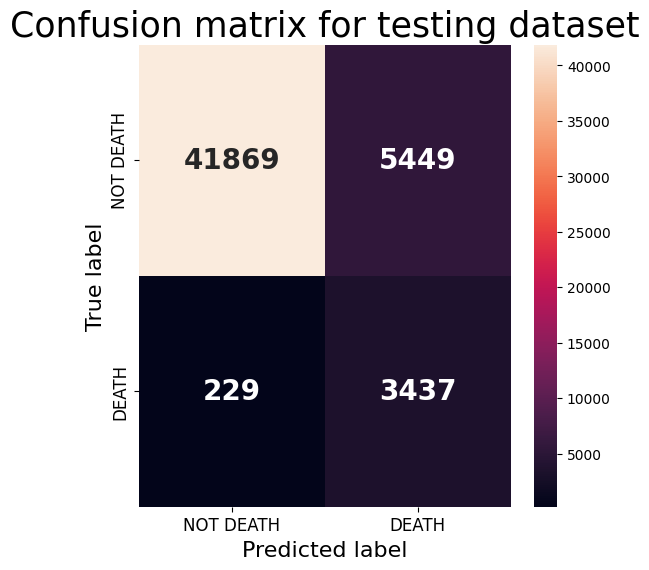

In [ ]:
y1_hat = search.best_estimator_.predict(X_test)
print('Results of test set prediction analyzing:')
print(' ')
print('Classification report:')
print(classification_report(y_test, y1_hat))
print(' ')
print('Accuracy of prediction:')
print(accuracy_score(y_test, y1_hat))
print(' ')
print("roc-auc score")
print(roc_auc_score(y_test, y1_hat))
print(' ')
print('Confusion matrix:')
_, ax = plt.subplots(figsize=(6,6))
ax = sns.heatmap(confusion_matrix(y_test, y1_hat), annot=True, fmt='d', annot_kws={"size": 20, "weight": "bold"})
labels = ['NOT DEATH', 'DEATH']
ax.set_xticklabels(labels, fontsize=12)
ax.set_yticklabels(labels, fontsize=12)
ax.set_ylabel('True label', fontsize=16)
ax.set_xlabel('Predicted label', fontsize=16)
ax.set_title('Confusion matrix for testing dataset', fontsize = 25)

DTree gives us model with better recall for class 1 but with worse precision. So it gives more weight to factors which are in red zone for Logistic regression.

1. The model has even higher recall for "1" class = 0.94 than Logistic regression but lower precision = 0.38. Avg weighted f1 score = 0.91 for both classes and it is lower than LorR f1 score (Logistic Regression avg weighted f1 score = 0.92).
3. ROC_AUC score equals to 0.909 This result is higher than ROC_AUC score for Logistic Regression.
4. Accuracy result is 0.89 (lower than LogR has) but for such imbalanced it is not so essential.

Let's visualize a tree:

Accuracy: 0.9448454417072023

              precision    recall  f1-score   support

           0       0.95      0.99      0.97     47318
           1       0.79      0.32      0.45      3666

    accuracy                           0.94     50984
   macro avg       0.87      0.66      0.71     50984
weighted avg       0.94      0.94      0.93     50984


Average 5-Fold CV Score: 0.9456 , Standard deviation: 0.0025


Text(0.5, 1.0, 'Confusion Matrix - Random Forest')

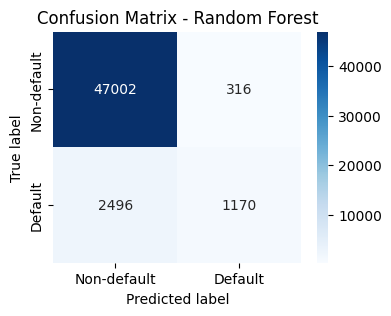

In [ ]:
Ran = RandomForestClassifier(criterion= 'entropy', max_depth= 5,random_state=0)
Ran.fit(X_train, y_train)
y_pred = Ran.predict(X_test)
print('Accuracy:',accuracy_score(y_pred,y_test))

## 5-fold cross-validation
cv_scores =cross_val_score(Ran, X, y, cv=5)

# Print the 5-fold cross-validation scores
print()
print(classification_report(y_test, y_pred))
print()
print("Average 5-Fold CV Score: {}".format(round(np.mean(cv_scores),4)),
      ", Standard deviation: {}".format(round(np.std(cv_scores),4)))

plt.figure(figsize=(4,3))
ConfMatrix = confusion_matrix(y_test,Ran.predict(X_test))
sns.heatmap(ConfMatrix,annot=True, cmap="Blues", fmt="d",
            xticklabels = ['Non-default', 'Default'],
            yticklabels = ['Non-default', 'Default'])
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.title("Confusion Matrix - Random Forest")

In [ ]:
X_train, X_test, y_train, y_test

(         USMER  RETURNED_HOME  INTUBED  PNEUMONIA  PREGNANT  DIABETES  COPD  \
 237574       1              1        0          0         0         0     0   
 304329       0              0        0          0         0         0     0   
 442698       0              1        0          0         0         0     0   
 990764       0              1        0          0         0         0     0   
 1022568      1              1        0          1         0         0     0   
 ...        ...            ...      ...        ...       ...       ...   ...   
 606369       0              1        0          0         0         0     0   
 258639       1              1        0          0         0         0     0   
 869180       1              1        0          0         0         0     0   
 426817       0              0        0          0         0         1     1   
 436115       0              1        0          0         0         0     0   
 
          ASTHMA  INMSUPR  HIPERTENSIO

In [ ]:
X_train

,USMER,RETURNED_HOME,INTUBED,PNEUMONIA,PREGNANT,DIABETES,COPD,ASTHMA,INMSUPR,HIPERTENSION,OTHER_DISEASE,CARDIOVASCULAR,OBESITY,RENAL_CHRONIC,TOBACCO,ICU,TEST_RESULT,AGE_0-9,AGE_10-19,AGE_20-29,AGE_30-39,AGE_40-49,AGE_50-59,AGE_60-69,AGE_70-79,AGE_80-89,AGE_OVER_90,WOMAN,MAN
237574,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1
304329,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0
442698,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,1
990764,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1
1022568,1,1,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
606369,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0
258639,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0
869180,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1
426817,0,0,0,0,0,1,1,0,0,1,1,1,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0


In [ ]:
X_train.columns 

Index(['USMER', 'RETURNED_HOME', 'INTUBED', 'PNEUMONIA', 'PREGNANT',
       'DIABETES', 'COPD', 'ASTHMA', 'INMSUPR', 'HIPERTENSION',
       'OTHER_DISEASE', 'CARDIOVASCULAR', 'OBESITY', 'RENAL_CHRONIC',
       'TOBACCO', 'ICU', 'TEST_RESULT', 'AGE_0-9', 'AGE_10-19', 'AGE_20-29',
       'AGE_30-39', 'AGE_40-49', 'AGE_50-59', 'AGE_60-69', 'AGE_70-79',
       'AGE_80-89', 'AGE_OVER_90', 'WOMAN', 'MAN'],
      dtype='object')

In [ ]:
from joblib import dump,load
import pickle

In [ ]:

pickle.dump(estimator,open("model.pkl","wb"))

In [ ]:
pickle_model=pickle.load(open("model.pkl","rb"))

In [ ]:
pickle

<module 'pickle' from 'c:\\Program Files\\Python311\\Lib\\pickle.py'>